In [ ]:
import sys

# install mirp
!{sys.executable} -m pip install --upgrade -q mirp

# install tcia utils for downloading example data
!{sys.executable} -m pip install --upgrade -q tcia_utils

In [34]:
from mirp import extract_mask_labels
from mirp import extract_image_parameters
from mirp import extract_images
from mirp import extract_features
import pandas as pd
from tcia_utils import nbia

# Download example data

In this example we will use the [Soft-tissue-Sarcoma](http://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS) dataset from The Cancer Imaging Archive.  Please be sure to abide by the [TCIA Data Usage Policy and Restrictions](https://www.cancerimagingarchive.net/data-usage-policies-and-restrictions/) by including this citation anywhere these data are being discussed:

```Vallières, Martin, Freeman, Carolyn R., Skamene, Sonia R., & El Naqa, Issam. (2015). A radiomics model from joint FDG-PET and MRI texture features for the prediction of lung metastases in soft-tissue sarcomas of the extremities (Soft-tissue-Sarcoma) [Dataset]. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS```

In order to download the data we'll utilize [tcia_utils](https://pypi.org/project/tcia-utils/).  These commands will demonstrate how to create a dataframe of image and segmentation metadata that we can use to execute mirp commands, as well as how to download the segmentations (RTSTRUCT) and reference MRIs to a folder called `tciaDownload/< SeriesInstanceUID`.  

In [11]:
# download an inventory of all scans in the Soft-tissue-Sarcoma dataset
series_metadata = nbia.getSeries(collection = "Soft-tissue-Sarcoma", format = "df")

# sort it display the first subject's scans
series_metadata = series_metadata.sort_values(by=['PatientID', 'StudyInstanceUID', 'SeriesNumber'], ascending=[True, True, True])
series_metadata[series_metadata['PatientID'].isin(series_metadata['PatientID'].unique()[:1])]

2024-05-02 13:00:38,135:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getSeries with parameters {'Collection': 'Soft-tissue-Sarcoma'}


,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDate,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,Manufacturer,ManufacturerModelName,SoftwareVersions,ImageCount,TimeStamp,LicenseName,LicenseURI,CollectionURI,FileSize,ProtocolName
192,1.3.6.1.4.1.14519.5.2.1.5168.1900.269249420684...,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,RTSTRUCT,2009-10-17 00:00:00.0,RTstruct_T2FS,EXTREMITY,1,Soft-tissue-Sarcoma,STS_001,MIM Software Inc.,MIM,6.3.9,1,2020-05-21 15:26:48.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,793954,NaN
193,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,RTSTRUCT,2009-10-17 00:00:00.0,RTstruct_T1,EXTREMITY,1,Soft-tissue-Sarcoma,STS_001,MIM Software Inc.,MIM,6.3.9,1,2020-05-21 15:26:45.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,1053424,NaN
58,1.3.6.1.4.1.14519.5.2.1.5168.1900.267475167888...,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,MR,2000-09-03 00:00:00.0,AXIAL SE T2 FAT SAT - RESEARCH,EXTREMITY,10,Soft-tissue-Sarcoma,STS_001,SIEMENS,Avanto,syngo MR 2004V 4VB11D,40,2020-05-21 15:26:48.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,11888878,NaN
59,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,MR,2000-09-03 00:00:00.0,AXIAL SE T1 - RESEARCH,EXTREMITY,11,Soft-tissue-Sarcoma,STS_001,SIEMENS,Avanto,syngo MR 2004V 4VB11D,40,2020-05-21 15:26:46.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,21063524,NaN
107,1.3.6.1.4.1.14519.5.2.1.5168.1900.279539551699...,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PT,2000-09-07 00:00:00.0,PET AC,EXTREMITY,1,Soft-tissue-Sarcoma,STS_001,GE MEDICAL SYSTEMS,Discovery ST,36.14,267,2020-05-21 15:27:04.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,9682406,NaN
188,1.3.6.1.4.1.14519.5.2.1.5168.1900.262680089418...,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,RTSTRUCT,2000-09-07 00:00:00.0,RTstruct_PET,EXTREMITY,1,Soft-tissue-Sarcoma,STS_001,MIM Software Inc.,MIM,6.3.9,1,2020-05-21 15:26:51.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,1177142,NaN
189,1.3.6.1.4.1.14519.5.2.1.5168.1900.294304652189...,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,RTSTRUCT,2000-09-07 00:00:00.0,RTstruct_CT,EXTREMITY,1,Soft-tissue-Sarcoma,STS_001,MIM Software Inc.,MIM,6.3.9,1,2020-05-21 15:27:17.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,1184960,NaN
194,1.3.6.1.4.1.14519.5.2.1.5168.1900.147597676388...,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,RTSTRUCT,2000-09-07 00:00:00.0,RTstruct_AlignedT1toPET,EXTREMITY,1,Soft-tissue-Sarcoma,STS_001,MIM Software Inc.,MIM,6.3.9,1,2020-05-21 15:26:48.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,1216454,NaN
195,1.3.6.1.4.1.14519.5.2.1.5168.1900.182565104594...,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,RTSTRUCT,2000-09-07 00:00:00.0,RTstruct_AlignedT2FStoPET,EXTREMITY,1,Soft-tissue-Sarcoma,STS_001,MIM Software Inc.,MIM,6.3.9,1,2020-05-21 15:26:48.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,1216336,NaN
80,1.3.6.1.4.1.14519.5.2.1.5168.1900.293609116849...,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,CT,2000-09-07 00:00:00.0,CT IMAGES - RESEARCH,EXTREM

After reviewing the data, let's say we want to focus on the T1 segmentations.  First we'll extract the SeriesInstanceUIDs and other key information to a new dataframe.

In [8]:
# Copy only the "RTstruct_T1" segmentation metadata to a new dataframe
seg_metadata = series_metadata[series_metadata['SeriesDescription'] == "RTstruct_T1"].copy().reset_index(drop=True)
seg_metadata = seg_metadata[['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesDescription', 'Modality', 'BodyPartExamined']]

seg_metadata

,PatientID,StudyInstanceUID,SeriesInstanceUID,SeriesDescription,Modality,BodyPartExamined
0,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,RTstruct_T1,RTSTRUCT,EXTREMITY
1,STS_002,1.3.6.1.4.1.14519.5.2.1.5168.1900.301696644941...,1.3.6.1.4.1.14519.5.2.1.5168.1900.337975716601...,RTstruct_T1,RTSTRUCT,EXTREMITY
2,STS_003,1.3.6.1.4.1.14519.5.2.1.5168.1900.141476737507...,1.3.6.1.4.1.14519.5.2.1.5168.1900.200331945037...,RTstruct_T1,RTSTRUCT,EXTREMITY
3,STS_004,1.3.6.1.4.1.14519.5.2.1.5168.1900.168034891325...,1.3.6.1.4.1.14519.5.2.1.5168.1900.336911320247...,RTstruct_T1,RTSTRUCT,EXTREMITY
4,STS_005,1.3.6.1.4.1.14519.5.2.1.5168.1900.224608962105...,1.3.6.1.4.1.14519.5.2.1.5168.1900.217450819413...,RTstruct_T1,RTSTRUCT,EXTREMITY
5,STS_006,1.3.6.1.4.1.14519.5.2.1.5168.1900.235629096015...,1.3.6.1.4.1.14519.5.2.1.5168.1900.970302281966...,RTstruct_T1,RTSTRUCT,EXTREMITY
6,STS_007,1.3.6.1.4.1.14519.5.2.1.5168.1900.311778395054...,1.3.6.1.4.1.14519.5.2.1.5168.1900.192924979232...,RTstruct_T1,RTSTRUCT,EXTREMITY
7,STS_008,1.3.6.1.4.1.14519.5.2.1.5168.1900.132619255485...,1.3.6.1.4.1.14519.5.2.1.5168.1900.126539531476...,RTstruct_T1,RTSTRUCT,EXTREMITY
8,STS_009,1.3.6.1.4.1.14519.5.2.1.5168.1900.631882130174...,1.3.6.1.4.1.14519.5.2.1.5168.1900.330588306923...,RTstruct_T1,RTSTRUCT,EXTREMITY
9,STS_010,1.3.6.1.4.1.14519.5.2.1.5168.1900.154535988064...,1.3.6.1.4.1.14519.5.2.1.5168.1900.302331428514...,RTstruct_T1,RTSTRUCT,EXTREMITY


Next we'll add a ReferencedSeriesInstanceUID column and use the TCIA API to look up the SeriesInstanceUID of the original T1 scans that were segmented.

In [ ]:
# Create an empty list to store the referenced series instance UIDs
referenced_series_uids = []

# Iterate through each row in the DataFrame and fetch the referenced series instance UID
for index, row in seg_metadata.iterrows():
    series_instance_uid = row['SeriesInstanceUID']
    referenced_series_uid = nbia.getSegRefSeries(series_instance_uid)
    referenced_series_uids.append(referenced_series_uid)

# Add the list of referenced series instance UIDs as a new column in the DataFrame
seg_metadata['ReferencedSeriesInstanceUID'] = referenced_series_uids

Now we can download some images.  We'll start with 3 subjects, but you can change or remove the number parameter if you like.

In [10]:
# set the number of patients or use None to download the full set of scans
num_patients = 3

if num_patients is None:
    uids_list = list(seg_metadata['SeriesInstanceUID']) + list(seg_metadata['ReferencedSeriesInstanceUID'])
else:
    selected_patients = seg_metadata.head(num_patients)
    uids_list = list(selected_patients['SeriesInstanceUID']) + list(selected_patients['ReferencedSeriesInstanceUID'])

# Pass the uids_list to nbia.downloadSeries(uids) for downloading
nbia.downloadSeries(uids_list, input_type = "list")


2024-05-02 12:56:32,305:INFO:Downloading 6 Series Instance UIDs (scans).
2024-05-02 12:56:32,306:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471360697610771464320 already downloaded.
2024-05-02 12:56:32,307:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.5168.1900.337975716601136724657907147584 already downloaded.
2024-05-02 12:56:32,307:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.5168.1900.200331945037361660113060575059 already downloaded.
2024-05-02 12:56:32,308:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266075940866375712555 already downloaded.
2024-05-02 12:56:32,308:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.5168.1900.103003228939916338240851002298 already downloaded.
2024-05-02 12:56:32,309:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.5168.1900.900154069973480789614361551267 already downloaded.
2024-05-02 12:56:32,310:INFO:Downloaded 0 out of 6 Series Instance UIDs (scans).
0 failed to download.
6 previously downloaded.


In [12]:
selected_patients

,PatientID,StudyInstanceUID,SeriesInstanceUID,SeriesDescription,Modality,BodyPartExamined,ReferencedSeriesInstanceUID
0,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,RTstruct_T1,RTSTRUCT,EXTREMITY,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...
1,STS_002,1.3.6.1.4.1.14519.5.2.1.5168.1900.301696644941...,1.3.6.1.4.1.14519.5.2.1.5168.1900.337975716601...,RTstruct_T1,RTSTRUCT,EXTREMITY,1.3.6.1.4.1.14519.5.2.1.5168.1900.103003228939...
2,STS_003,1.3.6.1.4.1.14519.5.2.1.5168.1900.141476737507...,1.3.6.1.4.1.14519.5.2.1.5168.1900.200331945037...,RTstruct_T1,RTSTRUCT,EXTREMITY,1.3.6.1.4.1.14519.5.2.1.5168.1900.900154069973...


# Finding mask labels

Radiomics features are typically computed from regions of interest, such as a tumour. These regions are delineated by experts or auto-segmentation AI, and stored as segmentation masks. MIRP needs to know which mask label (region of interest) should be used for computing features. A first step is to identify which mask labels exist. This can be done using the extract_mask_labels function. We can use our previously created dataframe to tell MIRP where the masks can be found.

In [22]:
# Create an empty DataFrame to store the concatenated results
all_labels = pd.DataFrame()

# Loop through the selected_patients DataFrame
for index, row in selected_patients.iterrows():
    # Set seg_path for each row
    seg_path = "tciaDownload/" + row['SeriesInstanceUID'] + "/1-1.dcm"
    # Set labels by calling extract_mask_labels(mask = seg_path)
    labels = extract_mask_labels(mask=seg_path)
    
    # Concatenate the results into the all_labels DataFrame
    all_labels = pd.concat([all_labels, labels])
    
all_labels

tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471360697610771464320/1-1.dcm
tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900.337975716601136724657907147584/1-1.dcm
tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900.200331945037361660113060575059/1-1.dcm


,sample_name,dir_path,file_path,roi_label,mask_index
0,STS_001,tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900...,1-1.dcm,GTV_Mass,0
1,STS_001,tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900...,1-1.dcm,GTV_Edema,0
0,STS_002,tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900...,1-1.dcm,GTV_Mass,0
1,STS_002,tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900...,1-1.dcm,GTV_Edema,0
0,STS_003,tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900...,1-1.dcm,GTV_Mass,0
1,STS_003,tciaDownload/1.3.6.1.4.1.14519.5.2.1.5168.1900...,1-1.dcm,GTV_Edema,0


We are lucky that all masks are consistently labelled. GTV_Mass and GTV_Edema both refer to the gross tumour volume, i.e. that part of the tumour that is visible in medical imaging. GTV-Edema also covers fluid surrounding the gross tumour volume itself.

# Visualising images
It is often useful to inspect images before computing radiomics features. External viewers for DICOM and many other image types exist, but MIRP also has a simple visualisation tool. You can visualise images by exporting them in MIRP internal formats using extract_images:

In [24]:
selected_patient

,PatientID,StudyInstanceUID,SeriesInstanceUID,SeriesDescription,Modality,BodyPartExamined,ReferencedSeriesInstanceUID
2,STS_003,1.3.6.1.4.1.14519.5.2.1.5168.1900.141476737507...,1.3.6.1.4.1.14519.5.2.1.5168.1900.200331945037...,RTstruct_T1,RTSTRUCT,EXTREMITY,1.3.6.1.4.1.14519.5.2.1.5168.1900.900154069973...


In [26]:
# choose a patient to visualize
patient_id = "STS_003"

# filter the dataframe to that patient
selected_patient = selected_patients[selected_patients['PatientID'] == patient_id]

# Set seg_path and image_path
for index, row in selected_patient.iterrows():
    seg_path = "tciaDownload/" + row['SeriesInstanceUID'] + "/1-1.dcm"
    image_path = "tciaDownload/" + row['ReferencedSeriesInstanceUID']

# extract parameters
images = extract_images(image = image_path, 
                            mask = seg_path,
                            roi_name = "GTV_Mass",
                            image_export_format = "native")

2024-05-02 13:52:33,743:INFO:Initialising image extraction using mr images for STS_003.


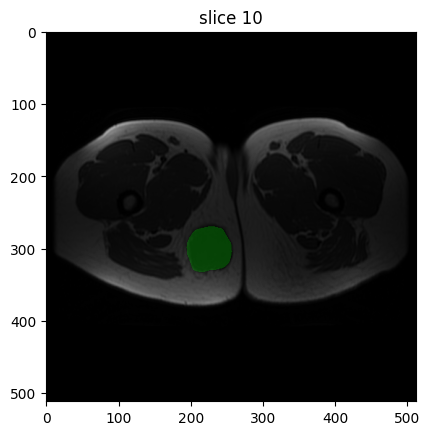

In [27]:
image, mask = images[0]
image[0].show(mask=mask[0], slice_id=10)

There's also a tcia_utils function for this you might want to try.  It'd be great if we could collaborate on this in the future so we're not both maintaining something to do this.  I'd much rather not be in the business of doing visualization if you're interested in rolling this function into your tool and improving it (there are issues with some image modalities and segmentation types) but I couldn't find anything super simple to do what we're both trying to achieve here so I had a summer intern help put this together last year.

In [30]:
nbia.viewSeriesAnnotation(seriesPath = image_path, annotationPath = seg_path)

interactive(children=(Checkbox(value=False, description='suppress_warnings'), IntSlider(value=17, description=…

# Assessing image metadata
Image metadata are important for understanding the image and how it was acquired and reconstructed. MIRP allows for exporting image metadata from DICOM and other image formats, though for non-DICOM formats metadata will be considerably more limited.

In [31]:
# Create an empty DataFrame to store the concatenated results
all_parameters = pd.DataFrame()

# Loop through the selected_patients DataFrame
for index, row in selected_patients.iterrows():
    # Set seg_path for each row
    image_path = "tciaDownload/" + row['ReferencedSeriesInstanceUID']
    # Extract parameters for each image series
    parameters = extract_image_parameters(image = image_path)
    
    # Concatenate the results into the all_labels DataFrame
    all_parameters = pd.concat([all_parameters, parameters])
    
all_parameters

Mismatch between slice thickness (4.0) and actual slice spacing (5.2). The actual slice spacing will be used.
Mismatch between slice thickness (6.0) and actual slice spacing (7.0). The actual slice spacing will be used.


,sample_name,modality,spacing_z,spacing_y,spacing_x,scanner_type,manufacturer,image_type,scanning_sequence,scanning_sequence_variant,image_index
0,STS_001,mr,5.2,0.390625,0.390625,Avanto,SIEMENS,"['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM']",SE,"['SK', 'SP', 'OSP']",0
0,STS_002,mr,7.0,0.892857,0.892857,Intera,Philips Medical Systems,"['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']",SE,OSP,0
0,STS_003,mr,7.0,0.781300,0.781300,Signa HDxt,GE MEDICAL SYSTEMS,"['ORIGINAL', 'PRIMARY', 'OTHER']",SE,SK,0


Only known metadata are shown. For example, magnetic field strength was not present in the image metadata in this example.

The metadata have important implications for the image processing:

* The in-plane resolution is much higher than the distance between slices. This suggests that features should be computed by slice, instead in 3D.
* The in-plane resolution differs between patients. This suggests that the images should be resampled to isotropic pixel sizes, e.g. 1.0 by 1.0 mm.
* All three images were recorded in different scanners. This suggests that MR intensities cannot be compared between patients, and should be standardised.

# Computing features
The presented metadata suggest that image processing is required to make the MR images more comparable between patients. We will define three image processing steps:

1. Image processing and feature computation is performed by slice (by_slice=True) due to large distances between image slices.
2. In-plane resolution is resampled to 1.0 by 1.0 mm (new_spacing=1.0).
3. Intensities are normalised, here using z-normalisation (intensity_normalisation="standardisation").

In addition, we need to define parameters related to intensity discretisation for computing histogram-based and texture features. Since intensities were normalised using z-normalisation, we will use a fixed bin number algorithm `(base_discretisation_method="fixed_bin_number")` with 16 bins `(base_discretisation_n_bins=16)`.

In [47]:
# Create an empty list to store the DataFrames
all_features_list = []

# Loop through the selected_patients DataFrame
for index, row in selected_patients.iterrows():
    # Set image_path and seg_path for each row
    image_path = "tciaDownload/" + row['ReferencedSeriesInstanceUID']
    seg_path = "tciaDownload/" + row['SeriesInstanceUID'] + "/1-1.dcm"
    
    # Extract parameters for each image series
    features = extract_features(
        image=image_path,
        mask=seg_path,
        roi_name="GTV_Mass",
        by_slice=True,
        intensity_normalisation="standardisation",
        new_spacing=1.0,
        base_discretisation_method="fixed_bin_number",
        base_discretisation_n_bins=16
    )
    
    # Extend the list of DataFrames
    all_features_list.extend(features)

# Concatenate all DataFrames in the list
all_features = pd.concat(all_features_list, ignore_index=True)
all_features


Mismatch between slice thickness (4.0) and actual slice spacing (5.2). The actual slice spacing will be used.
2024-05-02 17:52:05,241:INFO:Initialising feature computation using mr images for STS_001.
Mismatch between slice thickness (6.0) and actual slice spacing (7.0). The actual slice spacing will be used.
2024-05-02 17:52:11,210:INFO:Initialising feature computation using mr images for STS_002.
Mismatch between slice thickness (6.0) and actual slice spacing (7.0). The actual slice spacing will be used.
2024-05-02 17:52:15,356:INFO:Initialising feature computation using mr images for STS_003.


,sample_name,image_settings_id,image_modality,image_voxel_size_x,image_voxel_size_y,image_voxel_size_z,image_noise_level,image_noise_iteration_id,image_rotation_angle,image_translation_x,...,ngl_hdhge_d1_a0.0_2d_fbn_n16,ngl_glnu_d1_a0.0_2d_fbn_n16,ngl_glnu_norm_d1_a0.0_2d_fbn_n16,ngl_dcnu_d1_a0.0_2d_fbn_n16,ngl_dcnu_norm_d1_a0.0_2d_fbn_n16,ngl_dc_perc_d1_a0.0_2d_fbn_n16,ngl_gl_var_d1_a0.0_2d_fbn_n16,ngl_dc_var_d1_a0.0_2d_fbn_n16,ngl_dc_entr_d1_a0.0_2d_fbn_n16,ngl_dc_energy_d1_a0.0_2d_fbn_n16
0,STS_001,,mr,1.0,1.0,5.2,0.0,NaN,0.0,0.0,...,649.904779,685.643163,0.202679,573.379973,0.164149,1.0,2.124407,2.835808,5.207281,0.034652
1,STS_002,,mr,1.0,1.0,7.0,0.0,NaN,0.0,0.0,...,731.317187,232.044296,0.208755,212.059230,0.183419,1.0,3.301315,5.169630,5.048137,0.050158
2,STS_003,,mr,1.0,1.0,7.0,0.0,NaN,0.0,0.0,...,608.689328,472.701740,0.345461,334.257475,0.238191,1.0,3.232402,5.422279,4.222418,0.132661


This results in a pandas.DataFrame that has a row per image and mask. The first several columns contain parameters related to that image and mask, and how these were processed. After these, feature values are shown. These can be used for, e.g., machine learning using `scikit-learn <https://scikit-learn.org/stable/>`__ or `familiar <https://cran.r-project.org/web/packages/familiar/index.html>`__.

# CPTAC testing

In [2]:
metadata_urls = {
    "CPTAC-CCRCC": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_CPTAC-CCRCC_2023_07_14.csv",
    "CPTAC-PDA": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_CPTAC-PDA_2023_07_14.csv",
    "CPTAC-HNSCC": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_CPTAC-HNSCC_2023_07_14.csv",
    "CPTAC-UCEC": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_CPTAC-UCEC_2023_07_14.csv",
    "ACNS0332": "https://www.cancerimagingarchive.net/wp-content/uploads/ACNS0332_annotations_metadata-2023-08-03.csv",
    "AHOD0831": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_AHOD0831_01222023.csv",
    "AREN0532": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_AREN0532_01122023.csv",
    "AREN0533": "https://www.cancerimagingarchive.net/wp-content/uploads/AREN0533_Annotations_Metadata__01-12-2023.csv",
    "AREN0534": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_AREN0534_01122023.csv",
    "CALGB50303": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_CALGB50303_02272023.csv",
    "A091105": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_A091105_2023_11_06.csv",
    "ARAR0331": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_ARAR0331_2023_11_13.csv",
    "AHEP0731": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_AHEP0731_2024_1_3.csv",
    "ACRIN-HNSCC-FDG-PET-CT": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_ACRIN-HNSCC_2023_11_07.csv",
    "S0819": "https://www.cancerimagingarchive.net/wp-content/uploads/Metadata_Report_S0819_v2_2024-04-11.csv"
}

In [3]:
spreadsheet_url = metadata_urls["CPTAC-CCRCC"]
annotations = pd.read_csv(spreadsheet_url)
segmentations = annotations[annotations['Annotation Type'] == 'Segmentation'].copy()

In [34]:
segmentations

,PatientID,ClinicalTrialTimePointID,SeriesInstanceUID,SeriesDescription,StudyDescription,StudyInstanceUID,StudyDate,ROIVolume,DICOM Type,StructureSetLabel,Annotation Type,ReferencedSeriesInstanceUID
0,C3L-00815,Pre-dose,1.2.826.0.1.534147.667.2747872357.202342210195...,"Pre-dose, RT KIDNEY - 1",CT ABDOMEN AND PELVIS,1.3.6.1.4.1.14519.5.2.1.6450.2626.966065509516...,12/14/2008,15.649307 cc,RTSS,RT KIDNEY - 1,Segmentation,1.3.6.1.4.1.14519.5.2.1.6450.2626.731146207870...
2,C3L-00815,Pre-dose,1.2.826.0.1.534147.667.2747872357.202342210205...,"Pre-dose, RT KIDNEY - 1",CT ABDOMEN AND PELVIS,1.3.6.1.4.1.14519.5.2.1.6450.2626.966065509516...,12/14/2008,11.028182 cc,RTSS,RT KIDNEY - 1,Segmentation,1.3.6.1.4.1.14519.5.2.1.6450.2626.433707472480...
5,C3N-01828,Pre-dose,1.2.826.0.1.534147.756.812677238.2023221105309...,"Pre-dose, MEDIASTINAL LYMPH NODE - 1",NaN,1.3.6.1.4.1.14519.5.2.1.2932.1975.428743895940...,11/11/2009,4.327773 cc,RTSS,MEDIASTINAL LYMP,Segmentation,1.3.6.1.4.1.14519.5.2.1.2932.1975.167583085885...
7,C3N-01828,Pre-dose,1.2.826.0.1.534147.756.812677238.2023221105340...,"Pre-dose, MEDIASTINAL LYMPH NODE - 2",NaN,1.3.6.1.4.1.14519.5.2.1.2932.1975.428743895940...,11/11/2009,5.769816 cc,RTSS,MEDIASTINAL LYMP,Segmentation,1.3.6.1.4.1.14519.5.2.1.2932.1975.167583085885...
9,C3N-01828,Pre-dose,1.2.826.0.1.534147.756.812677238.2023221105456...,"Pre-dose, RT LUNG - 1",NaN,1.3.6.1.4.1.14519.5.2.1.2932.1975.428743895940...,11/11/2009,2.569422 cc,RTSS,RT LUNG - 1,Segmentation,1.3.6.1.4.1.14519.5.2.1.2932.1975.167583085885...
...,...,...,...,...,...,...,...,...,...,...,...,...
627,C3N-02265,Pre-dose,1.2.826.0.1.534147.756.812677238.2023222952214...,"Pre-dose, LT KIDNEY - 1",Abdomen^Jama_Brzuszna_3_Fazy_Opoznione (Adult),1.3.6.1.4.1.14519.5.2.1.3320.3273.100328277515...,10/10/2000,99.699933 cc,RTSS,LT KIDNEY - 1,Segmentation,1.3.6.1.4.1.14519.5.2.1.3320.3273.993902197210...
628,C3N-02265,Pre-dose,1.2.826.0.1.534147.667.2747872357.202342091138...,"Pre-dose, LT KIDNEY - 1",Abdomen^Jama_Brzuszna_3_Fazy_Opoznione (Adult),1.3.6.1.4.1.14519.5.2.1.3320.3273.100328277515...,10/10/2000,77.438023 cc,RTSS,LT KIDNEY - 1,Segmentation,1.3.6.1.4.1.14519.5.2.1.3320.3273.130862585164...
629,C3N-02265,Pre-dose,1.2.826.0.1.534147.667.2747872357.202342091516...,"Pre-dose, LT KIDNEY - 1",Abdomen^Jama_Brzuszna_3_Fazy_Opoznione (Adult),1.3.6.1.4.1.14519.5.2.1.3320.3273.100328277515...,10/10/2000,77.438023 cc,RTSS,LT KIDNEY - 1,Segmentation,1.3.6.1.4.1.14519.5.2.1.3320.3273.250200284425...
633,C3N-00305,Pre-dose,1.2.826.0.1.534147.756.812677238.2023216134927...,"Pre-dose, LT KIDNEY - 1",JAMA BRZUSZNA,1.3.6.1.4.1.14519.5.2.1.3320.3273.842160277180...,8/17/1999,32.340383 cc,RTSS,LT KIDNEY - 1,Segmentation,1.3.6.1.4.1.14519.5.2.1.3320.3273.278457569394...


In [5]:
def iterate_mask_labels(df, num_rows=None):
    all_labels = pd.DataFrame()
    
    if num_rows is None:
        num_rows = len(df)

    for i in range(num_rows):
        row = df.iloc[i]
        seg = row['SeriesInstanceUID']
        nbia.downloadSeries([seg], input_type = "list")
        seg_path = "tciaDownload/" + seg + "/1-1.dcm"
        labels = extract_mask_labels(mask = seg_path)

        # Concatenate the current labels with the previous ones
        all_labels = pd.concat([all_labels, labels])

    # Reset the index of the final dataframe
    all_labels.reset_index(drop=True, inplace=True)

    return all_labels

In [6]:
# Call the function
iterate_mask_labels(segmentations, num_rows=6)  # Change num_rows to the number of rows you want to process

2024-05-01 23:41:24,587:INFO:Downloading 2 Series Instance UIDs (scans).
2024-05-01 23:41:24,590:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.2626.731146207870088227735439657942 already downloaded.
2024-05-01 23:41:24,591:WARNING:Series 1.2.826.0.1.534147.667.2747872357.2023422101957101.4 already downloaded.
2024-05-01 23:41:24,592:INFO:Downloaded 0 out of 2 Series Instance UIDs (scans).
0 failed to download.
2 previously downloaded.
2024-05-01 23:41:25,660:INFO:Downloading 2 Series Instance UIDs (scans).
2024-05-01 23:41:25,660:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.2626.433707472480563408424899142107 already downloaded.
2024-05-01 23:41:25,661:WARNING:Series 1.2.826.0.1.534147.667.2747872357.2023422102056778.4 already downloaded.
2024-05-01 23:41:25,661:INFO:Downloaded 0 out of 2 Series Instance UIDs (scans).
0 failed to download.
2 previously downloaded.
2024-05-01 23:41:25,673:INFO:Downloading 2 Series Instance UIDs (scans).
2024-05-01 23:41:25,673:WARNING:Series 1.3.6.1.4.1.14

,sample_name,dir_path,file_path,roi_label,mask_index
0,C3L-00815,tciaDownload/1.2.826.0.1.534147.667.2747872357...,1-1.dcm,RT KIDNEY - 1,0
1,C3L-00815,tciaDownload/1.2.826.0.1.534147.667.2747872357...,1-1.dcm,RT KIDNEY - 1,0
2,C3N-01828,tciaDownload/1.2.826.0.1.534147.756.812677238....,1-1.dcm,MEDIASTINAL LYM,0
3,C3N-01828,tciaDownload/1.2.826.0.1.534147.756.812677238....,1-1.dcm,MEDIASTINAL LYM,0
4,C3N-01828,tciaDownload/1.2.826.0.1.534147.756.812677238....,1-1.dcm,RT LUNG - 1,0
5,C3N-01828,tciaDownload/1.2.826.0.1.534147.756.812677238....,1-1.dcm,RT LUNG - 2,0


In [12]:
def iterate_image_parameters(df, num_rows=None):
    all_parameters = pd.DataFrame()
    
    if num_rows is None:
        num_rows = len(df)

    for i in range(num_rows):
        row = df.iloc[i]
        series = row['ReferencedSeriesInstanceUID']
        nbia.downloadSeries([series], input_type = "list")
        series_path = "tciaDownload/" + series
        parameters = extract_image_parameters(image = series_path)
        
        all_parameters = pd.concat([all_parameters, parameters])
    
    # Reset the index of the final dataframe
    all_parameters.reset_index(drop=True, inplace=True)

    return all_parameters

In [13]:
iterate_image_parameters(segmentations, num_rows=6)

2024-05-01 23:48:38,394:INFO:Downloading 1 Series Instance UIDs (scans).
2024-05-01 23:48:38,395:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.2626.731146207870088227735439657942 already downloaded.
2024-05-01 23:48:38,395:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.
Mismatch between slice thickness (1.25) and actual slice spacing (0.6). The actual slice spacing will be used.
2024-05-01 23:48:39,176:INFO:Downloading 1 Series Instance UIDs (scans).
2024-05-01 23:48:39,176:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.2626.433707472480563408424899142107 already downloaded.
2024-05-01 23:48:39,177:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.
2024-05-01 23:48:40,003:INFO:Downloading 1 Series Instance UIDs (scans).
2024-05-01 23:48:40,004:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.2932.1975.167583085885136430018247234051 already downloaded.
2024-05-01 23:48:40,004:INFO:Downloaded 0 

,sample_name,modality,spacing_z,spacing_y,spacing_x,scanner_type,manufacturer,image_type,kernel,kvp,tube_current,exposure_time,exposure,contrast_agent,image_index
0,C3L-00815,ct,0.6,0.878906,0.878906,LightSpeed Pro 16,GE MEDICAL SYSTEMS,"['ORIGINAL', 'PRIMARY', 'AXIAL']",STANDARD,120.0,495.0,478.0,478.0,H2O & ISOVUE 370,0
1,C3L-00815,ct,0.6,0.878906,0.878906,LightSpeed Pro 16,GE MEDICAL SYSTEMS,"['ORIGINAL', 'PRIMARY', 'AXIAL']",STANDARD,120.0,495.0,478.0,478.0,H2O & ISOVUE 370,0
2,C3N-01828,ct,1.0,0.677734,0.677734,Mx8000 IDT 16,Philips,"['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']",C,120.0,264.0,NaN,NaN,CONTRAST,0
3,C3N-01828,ct,1.0,0.677734,0.677734,Mx8000 IDT 16,Philips,"['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']",C,120.0,264.0,NaN,NaN,CONTRAST,0
4,C3N-01828,ct,1.0,0.677734,0.677734,Mx8000 IDT 16,Philips,"['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']",C,120.0,264.0,NaN,NaN,CONTRAST,0
5,C3N-01828,ct,1.0,0.677734,0.677734,Mx8000 IDT 16,Philips,"['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']",C,120.0,264.0,NaN,NaN,CONTRAST,0


In [44]:
from mirp import extract_features

features = extract_features(
    image=os.path.join(save_dir, "sts_images"),
    image_sub_folder=os.path.join("mr_t1", "image"),
    mask=os.path.join(save_dir, "sts_images"),
    mask_sub_folder=os.path.join("mr_t1", "mask"),
    roi_name="GTV_Mass",
    by_slice=True,
    intensity_normalisation="standardisation",
    new_spacing=1.0,
    base_discretisation_method="fixed_bin_number",
    base_discretisation_n_bins=16
)

pd.concat(features)

Mismatch between slice thickness (6.0) and actual slice spacing (7.0). The actual slice spacing will be used.
Mismatch between slice thickness (4.0) and actual slice spacing (5.2). The actual slice spacing will be used.
2024-05-01 22:54:26,046:INFO:Initialising feature computation using mr images for STS_002.
2024-05-01 22:54:30,897:INFO:Initialising feature computation using mr images for STS_003.
Mismatch between slice thickness (6.0) and actual slice spacing (7.0). The actual slice spacing will be used.
2024-05-01 22:54:42,258:INFO:Initialising feature computation using mr images for STS_001.
Mismatch between slice thickness (4.0) and actual slice spacing (5.2). The actual slice spacing will be used.


,sample_name,image_settings_id,image_modality,image_voxel_size_x,image_voxel_size_y,image_voxel_size_z,image_noise_level,image_noise_iteration_id,image_rotation_angle,image_translation_x,...,ngl_hdhge_d1_a0.0_2d_fbn_n16,ngl_glnu_d1_a0.0_2d_fbn_n16,ngl_glnu_norm_d1_a0.0_2d_fbn_n16,ngl_dcnu_d1_a0.0_2d_fbn_n16,ngl_dcnu_norm_d1_a0.0_2d_fbn_n16,ngl_dc_perc_d1_a0.0_2d_fbn_n16,ngl_gl_var_d1_a0.0_2d_fbn_n16,ngl_dc_var_d1_a0.0_2d_fbn_n16,ngl_dc_entr_d1_a0.0_2d_fbn_n16,ngl_dc_energy_d1_a0.0_2d_fbn_n16
0,STS_002,,mr,1.0,1.0,7.0,0.0,NaN,0.0,0.0,...,731.317187,232.044296,0.208755,212.059230,0.183419,1.0,3.301315,5.169630,5.048137,0.050158
0,STS_003,,mr,1.0,1.0,7.0,0.0,NaN,0.0,0.0,...,608.689328,472.701740,0.345461,334.257475,0.238191,1.0,3.232402,5.422279,4.222418,0.132661
0,STS_001,,mr,1.0,1.0,5.2,0.0,NaN,0.0,0.0,...,649.904779,685.643163,0.202679,573.379973,0.164149,1.0,2.124407,2.835808,5.207281,0.034652
